# Weird, But Why? Explanable Outlier Detection

by Matthew Emery

<style>
.container{
    display: flex;
}
.col{
    flex: 1;
}
</style>

In [1]:
from scipy.io import loadmat
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import shap
import numpy as np
from yellowbrick.features import PCA

shap.initjs()

## What is an Outlier?

<img src="img/outliers.gif">

  <aside class="notes">
    An outlier is some data point that looks different from the rest of the data. Depending on the type of task and model, presence of outliers can skew conclusions.
  </aside>

## Outlier Detection (OD)

<img src="img/pyod.png">

  <aside class="notes">
    <ul>
    <li>Manual inspection becomes difficult in large datasets with high dimension</li>
    <li>Typically unsupervised</li>
    <li>This comes from PyOD</li>
    </ul>
  </aside>


## Data Example

 - Using a classic: Lympho dataset from the Outlier Detection DataSets
 - Lymphography is a medical imaging procedure to detect Lymph node-based cancers (mostly replaced by PET scans)
 - Contains 148 data points with 18 features and 6 outliers (Lymphoma cases)


In [2]:
data = loadmat("data/lympho.mat")
features = data['X']
labeler = LabelEncoder()
ground_truth = labeler.fit_transform(data['y'].ravel())
labels = ['Typical', 'Outlier']
feature_labels = ["lymphatics", "block_of_affere", "bl_of_lymph_c", "bl_of_lymph_s", "by_pass", "extravasates", "regeneration_of", "early_uptake_in", "lym_nodes_dimin", "lym_nodes_enlar", "changes_in_lym", "defect_in_node", "changes_in_node", "changes_in_stru", "special_forms", "dislocation_of", "exclusion_of_no", "no_of_nodes_in"]

## What does the data look like?

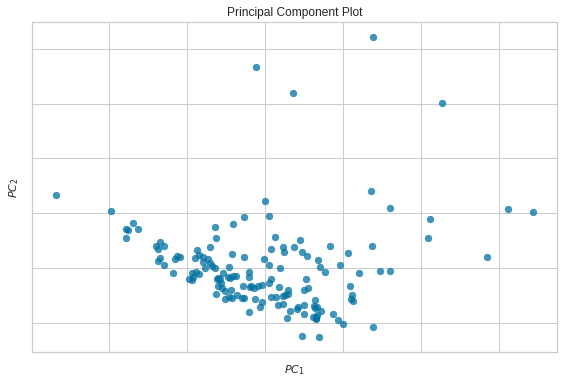

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [3]:
pca_visualizer = PCA(scale=True)
pca_visualizer.fit_transform(features)
pca_visualizer.show()

## What does the data look like?

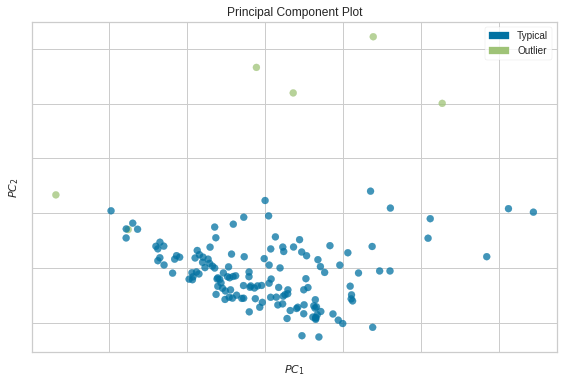

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [4]:
pca_visualizer = PCA(scale=True, classes=labels)
pca_visualizer.fit_transform(features, ground_truth)
pca_visualizer.show()

This used a library called yellowbrick that produces visualizations based off of scikit-learn objects.

Notice I said that there are 6 outliers. Five outliers are obvious, the sixth is not.

## Isolation Forests (IFs)
<img src="img/IsolationForest1.png">


  <aside class="notes">
<ul>
    <li>Most OD methods rely on a measure of distance</li>
    <li>Isolation Forests use extra random forest to partition the data</li>
    <li>Outliers are more likely to be in the minority class of any random split</li>
    <li>Data points that are consistently isolated near the top of a tree are outliers</li>
</ul>
  </aside>

## How'd We Do?

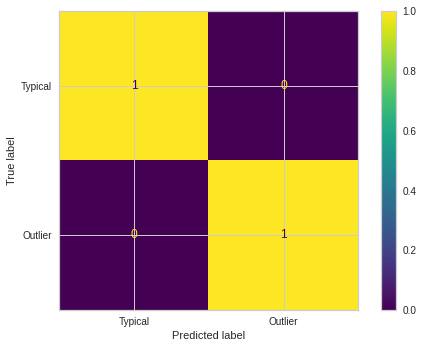

In [5]:
iso_forest = IsolationForest(random_state=1, n_jobs=-1, n_estimators=500, contamination=0.04)
model_prediction = iso_forest.fit_predict(features)
model_prediction = labeler.transform(np.vectorize(lambda x: 0 if x == 1 else 1)(model_prediction))
cm = confusion_matrix(model_prediction, ground_truth, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

## Explaining Outlier Detection

 - IF works great, but we don't know why an outlier is an outlier
 - Think about the dataset we are using here, would we want to remove any outlying data points?
 - 
 

## Shapley Values

 - A game theoretic approach
 - Each feature value is a player on a team, how much is each player's contribution worth?
 - The weight of feature value's contribution must be measured in coalition with every other feature value
 - This is extremely expensive!

## SHAP Values

 - SHAP (SHapley Additive exPlanations) are Shapley values applied to a machine learning model
 - SHAP values are local approximations of  into account the structure of models for much faster explanations

In [6]:
# Outlier
shap_explainer = shap.Explainer(iso_forest, algorithm='tree', feature_names=feature_labels)
shap_values = shap_explainer(features)
shap.force_plot(shap_values[0])

In [7]:
# Typical
shap.force_plot(shap_values[-1])

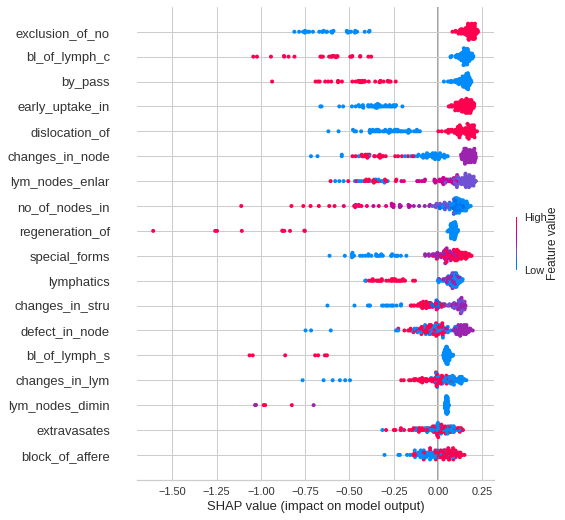

In [8]:
shap.summary_plot(shap_values)

## Bibliography

[1]“2.7. Novelty and Outlier Detection,” scikit-learn. https://scikit-learn/stable/modules/outlier_detection.html (accessed Jan. 03, 2022).
[2]S. Santoyo, “A Brief Overview of Outlier Detection Techniques,” Medium, Nov. 24, 2017. https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561 (accessed Jan. 02, 2022).
[3]“Detecting and preventing abuse on LinkedIn using isolation forests.” https://engineering.linkedin.com/blog/2019/isolation-forest (accessed Jan. 03, 2022).
[4]“Difference between Shapley values and SHAP for interpretable machine learning,” Stack Overflow. https://stackoverflow.com/questions/58203472/difference-between-shapley-values-and-shap-for-interpretable-machine-learning (accessed Jan. 04, 2022).
[5]E. Anello, “Interpretation of Isolation Forest with SHAP,” Medium, Nov. 02, 2021. https://pub.towardsai.net/interpretation-of-isolation-forest-with-shap-d1b6af93ae71 (accessed Dec. 27, 2021).
[6]F. T. Liu, K. M. Ting, and Z.-H. Zhou, “Isolation Forest,” in 2008 Eighth IEEE International Conference on Data Mining, Dec. 2008, pp. 413–422. doi: 10.1109/ICDM.2008.17.
[7]“ODDS – Outlier Detection DataSets.” http://odds.cs.stonybrook.edu/ (accessed Dec. 27, 2021).
[8]R. Sukumar, “SHAP Part 3: Tree SHAP,” Analytics Vidhya, Oct. 21, 2020. https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b (accessed Jan. 04, 2022).
[9]“UCI Machine Learning Repository: Lymphography Data Set.” https://archive.ics.uci.edu/ml/datasets/Lymphography (accessed Jan. 02, 2022).
